Note: we will be preparing our NLP processing with functions for future exploration of data. Functions make it more modular for us to edit and change queries to gather different insights.

In [13]:
import sqlite3
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import TypedDict
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from langgraph.graph import StateGraph

conn = sqlite3.connect('main.db')

## 1. Reading papers.csv and authors.csv provided

In [7]:
# Reading authors into df and into db
authors_df = pd.read_csv('authors.csv')
authors_df.to_sql('authors_raw', conn, if_exists = 'replace')
print("--- This is the authors data frame: ---")
display(authors_df.head())


# Reading papers into df and into db
papers_df = pd.read_csv('papers.csv')
papers_df.to_sql('papers_raw', conn, if_exists = 'replace')


# Some simple cleaning
papers_df['full_text'] = papers_df['full_text'].fillna(" ")
print("--- This is the papers data frame: ---")
display(papers_df.head())

--- This is the authors data frame: ---


source_id first_name    last_name institution
0         27       Alan       Murray         NaN
1         27    Anthony        Smith         NaN
2         27        Zoe       Butler         NaN
3         63      Yaser  Abu-Mostafa         NaN
4         60    Michael     Fleisher         NaN

--- This is the papers data frame: ---


source_id  year                                              title  \
0         27  1987                         Bit-Serial Neural Networks   
1         63  1987                        Connectivity Versus Entropy   
2         60  1987        The Hopfield Model with Multi-Level Neurons   
3         59  1987                               How Neural Nets Work   
4         69  1987  Spatial Organization of Neural Networks: A Pro...   

  abstract                                          full_text  
0      NaN  573 \n\nBIT - SERIAL NEURAL  NETWORKS \n\nAlan...  
1      NaN  1 \n\nCONNECTIVITY VERSUS ENTROPY \n\nYaser  S...  
2      NaN  278 \n\nTHE HOPFIELD MODEL WITH MUL TI-LEVEL N...  
3      NaN  442 \n\nAlan  Lapedes \nRobert  Farber \n\nThe...  
4      NaN  740 \n\nSPATIAL  ORGANIZATION  OF  NEURAL  NEn...

## 2. Preprocessing texts with nltk - removing stop words (non-semantic words)

In [16]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


# Function to turn all texts to lower case, removing punctuation and stopwords
def preprocess_text(text):
    # if not isinstance(text, str): ## might not be relevant later we see
    #     return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to C:\Users\script.pc
[nltk_data]     #93\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3. Performing Term Frequency-Inverse Document Frequency (TF-IDF) on research papers

In [17]:
# --- Step 1: Define the State ---
class SqlTfidfState(TypedDict):
    question: str  # User's question
    query: str     # Generated SQL query
    result: pd.DataFrame  # SQL query result
    answer: dict   # TF-IDF hot topics output


# --- Step 2: Generate SQL Query ---
# Currently simplified to only work with "hot topics"
def write_query(state: SqlTfidfState):
    """Generate SQL query dynamically based on user question."""
    question = state["question"]
    print(f"Generating SQL query for: {question}")
    
    # Example of simple question parsing to SQL query
    if "hot topics" in question.lower():
        query = "SELECT * FROM papers_raw"
    else:
        raise ValueError("Unsupported question format")
    
    return {"query": query}


# --- Step 3: Execute SQL Query ---
def execute_query(state: SqlTfidfState):
    """Execute the generated SQL query on SQLite."""
    query = state["query"]
    print(f"Executing SQL query: {query}")
    
    conn = sqlite3.connect("main.db")  # Connect to SQLite database
    result = pd.read_sql(query, conn)
    conn.close()
    
    return {"result": result}


# --- Step 4: Perform TF-IDF Analysis and Save to SQLite ---
def generate_hot_topics(state: SqlTfidfState):
    """Perform TF-IDF analysis, generate hot topics, and save to SQLite."""
    print("Performing TF-IDF analysis and saving results...")
    conn = sqlite3.connect("main.db")  # Connect to SQLite database
    df = state["result"]
    
    # Preprocess text (combine title and abstract)
    df['processed_text'] = (df['title'].fillna('') + ' ' + df['abstract'].fillna('')).apply(preprocess_text)
    
    # Group by year and calculate TF-IDF
    grouped = df.groupby('year')
    hot_topics = []
    
    for year, group in grouped:
        vectorizer = TfidfVectorizer(max_features=50)  # Allow more terms to ensure sorting accuracy
        tfidf_matrix = vectorizer.fit_transform(group['processed_text'].tolist())
        feature_names = vectorizer.get_feature_names_out()
        scores = tfidf_matrix.sum(axis=0).A1  # Sum scores across documents

        # Zip terms and scores, then sort in descending order
        sorted_terms_scores = sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)

        # Collect only the top terms and scores
        for term, score in sorted_terms_scores:
            hot_topics.append((int(year), term, round(score, 2)))
    
    # Save sorted hot topics to SQLite
    hot_topics_df = pd.DataFrame(hot_topics, columns=['year', 'term', 'score'])
    hot_topics_df.to_sql('hot_topics', conn, if_exists='replace', index=False)
    print("Hot topics saved to 'hot_topics' table in SQLite.")
    
    conn.close()
    
    # Group topics by year for further processing
    grouped_topics = hot_topics_df.groupby('year').apply(lambda x: list(zip(x['term'], x['score'])))
    return {"answer": grouped_topics.to_dict()}


# --- Step 5: Generate Final Output and Word Clouds ---
def generate_answer(state: SqlTfidfState):
    """Format the hot topics as a readable answer and generate word clouds."""
    print("Formatting the results and generating word clouds...")
    hot_topics = state["answer"]
    answer = "Hot Topics by Year:\n"

    all_terms = []  # Collect all terms for overall TF-IDF

    # Generate word clouds for each year
    for year, topics in hot_topics.items():
        # Print top terms
        print(f"Top 5 Hot Topics for Year {int(year)}:")
        for term, score in topics[:5]:
            print(f"  {term}: {score:.2f}")
        
        # Append to the answer string
        answer += f"\nYear {int(year)}:\n"
        for term, score in topics[:5]:
            answer += f"  {term}: {score:.2f}\n"
        
        # Collect all terms and scores for overall analysis
        all_terms.extend(topics)
        
        # Generate word cloud for this year
        topics_dict = dict(topics)
        wordcloud = WordCloud(
            width=800, height=400, background_color='white', relative_scaling=0.5
        ).generate_from_frequencies(topics_dict)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Hot Topics in {int(year)}", fontsize=16)
        plt.show()

## 4. Defining workflow and compiling all functions into nodes to execute a query

Generating SQL query for: What are the hot topics by year?
Executing SQL query: SELECT * FROM papers_raw
Performing TF-IDF analysis and saving results...
Hot topics saved to 'hot_topics' table in SQLite.
Formatting the results and generating word clouds...
Top 5 Hot Topics for Year 1987:
  neural: 14.93
  networks: 14.50
  learning: 7.48
  network: 6.85
  associative: 4.39


C:\Users\script.pc #93\AppData\Local\Temp\ipykernel_22508\2081235664.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_topics = hot_topics_df.groupby('year').apply(lambda x: list(zip(x['term'], x['score'])))


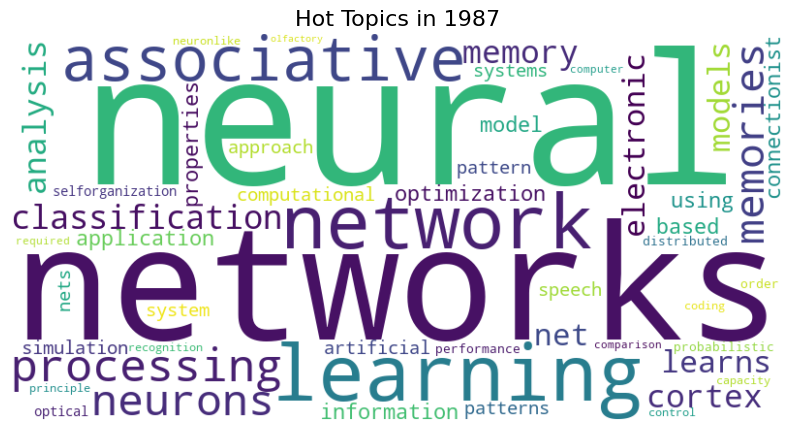

Top 5 Hot Topics for Year 1988:
  neural: 12.92
  network: 10.16
  networks: 9.61
  learning: 7.70
  analog: 5.97


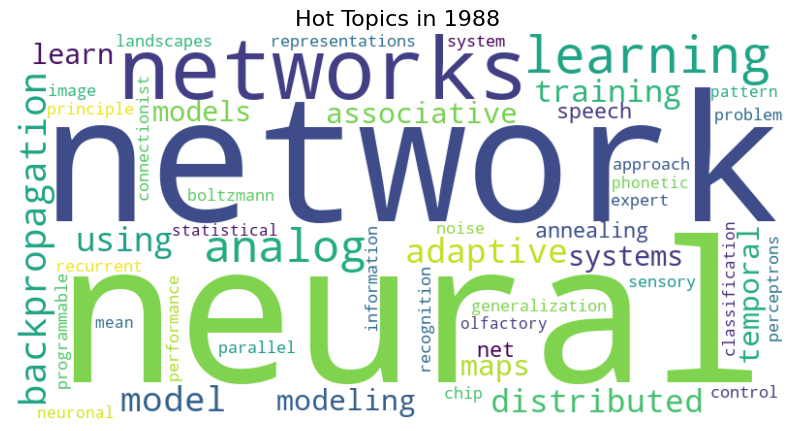

Top 5 Hot Topics for Year 1989:
  neural: 13.25
  networks: 12.25
  network: 8.52
  learning: 7.61
  recognition: 4.30


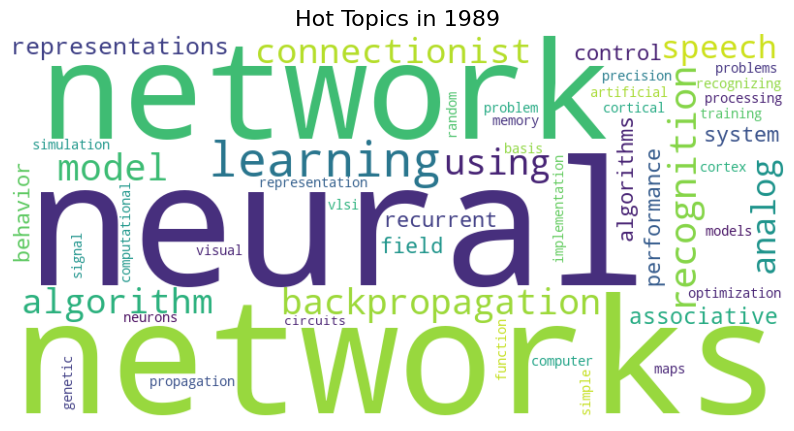

Top 5 Hot Topics for Year 1990:
  neural: 18.13
  networks: 14.88
  learning: 12.59
  network: 12.38
  recognition: 8.21


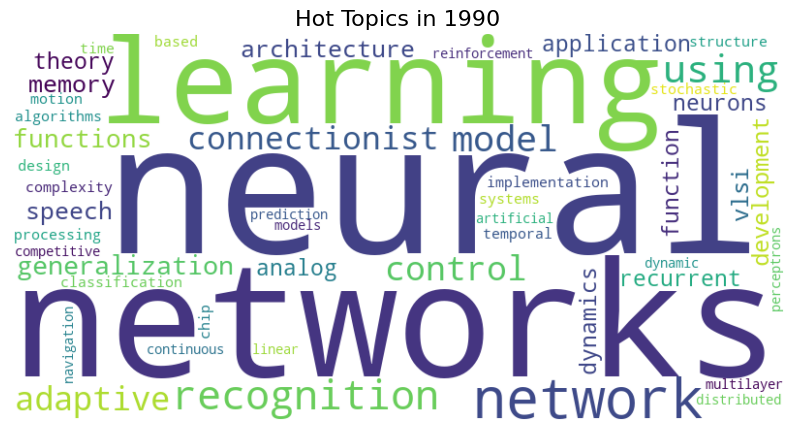

Top 5 Hot Topics for Year 1991:
  learning: 17.17
  neural: 16.52
  networks: 14.41
  network: 14.02
  recognition: 9.77


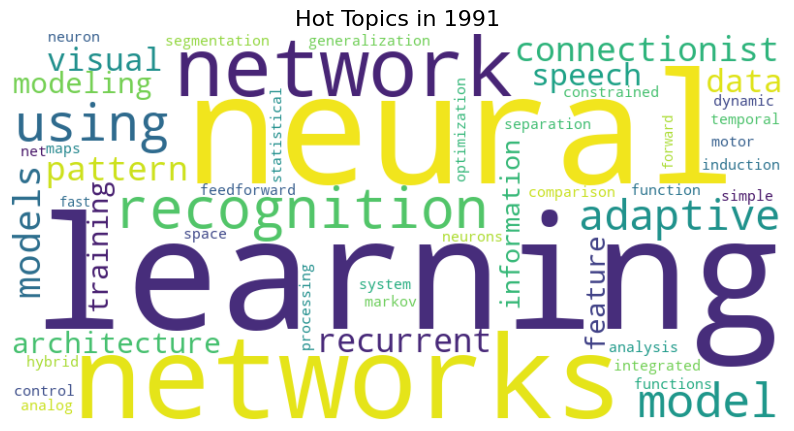

Top 5 Hot Topics for Year 1992:
  neural: 16.30
  networks: 15.59
  learning: 14.71
  model: 9.20
  network: 7.07


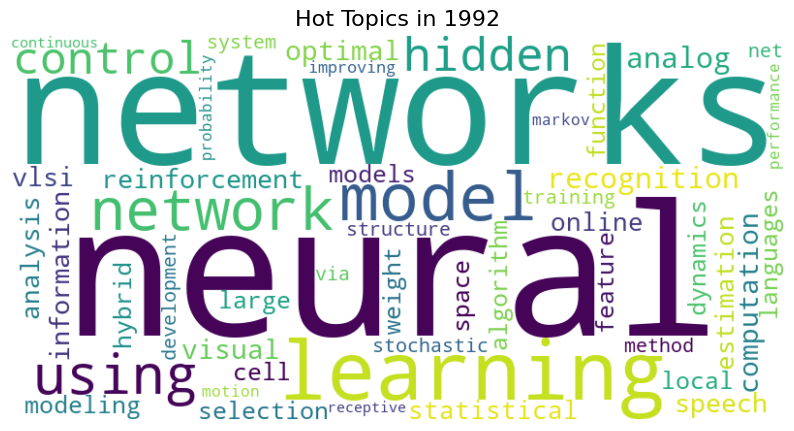

Top 5 Hot Topics for Year 1993:
  learning: 15.72
  neural: 15.10
  networks: 13.61
  network: 10.26
  using: 9.48


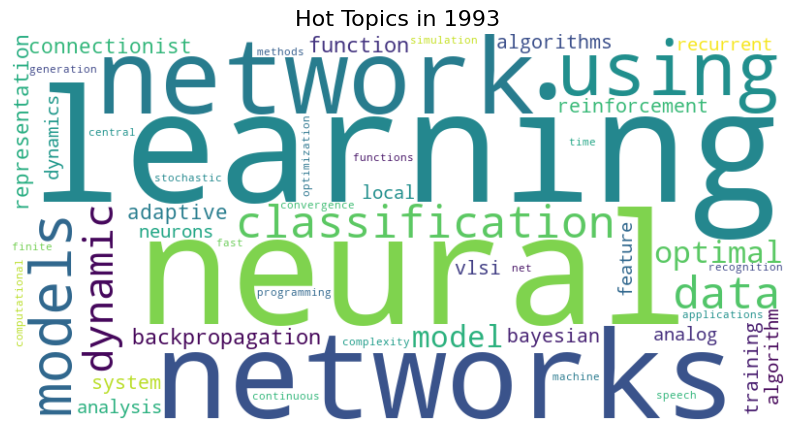

Top 5 Hot Topics for Year 1994:
  learning: 21.53
  neural: 15.16
  networks: 12.97
  using: 7.85
  network: 7.71


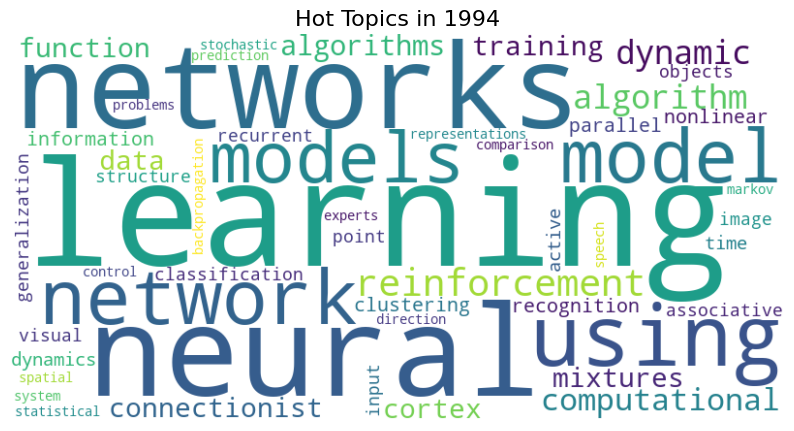

Top 5 Hot Topics for Year 1995:
  learning: 21.38
  networks: 15.67
  neural: 12.71
  using: 9.85
  model: 7.19


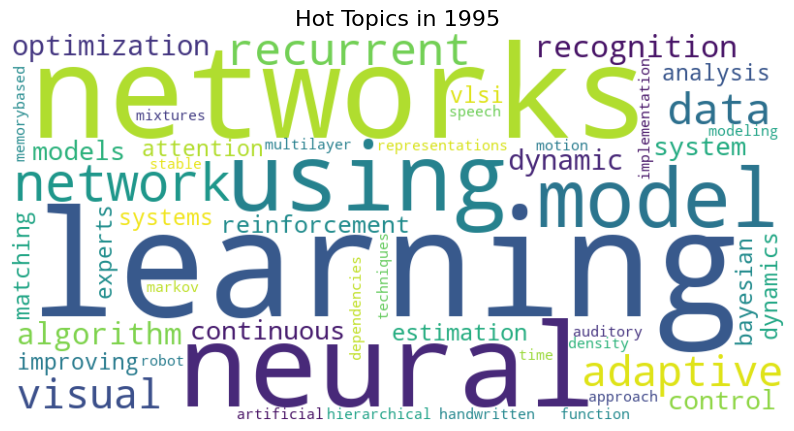

Top 5 Hot Topics for Year 1996:
  learning: 18.13
  networks: 10.92
  neural: 9.31
  using: 8.12
  network: 6.88


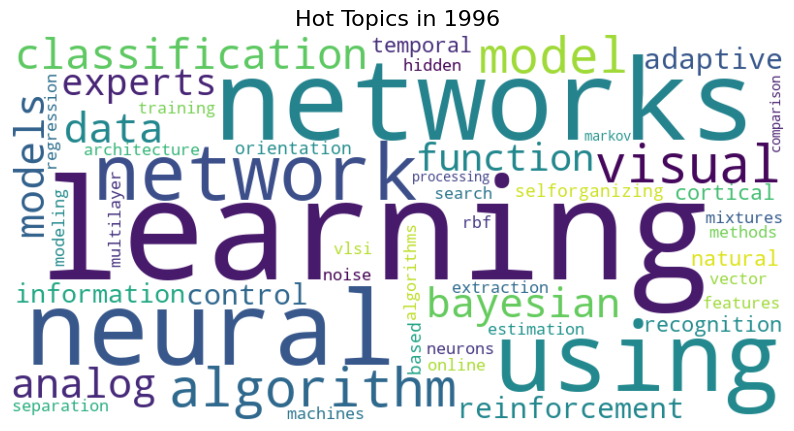

Top 5 Hot Topics for Year 1997:
  learning: 13.98
  neural: 10.51
  model: 8.58
  networks: 8.53
  using: 5.77


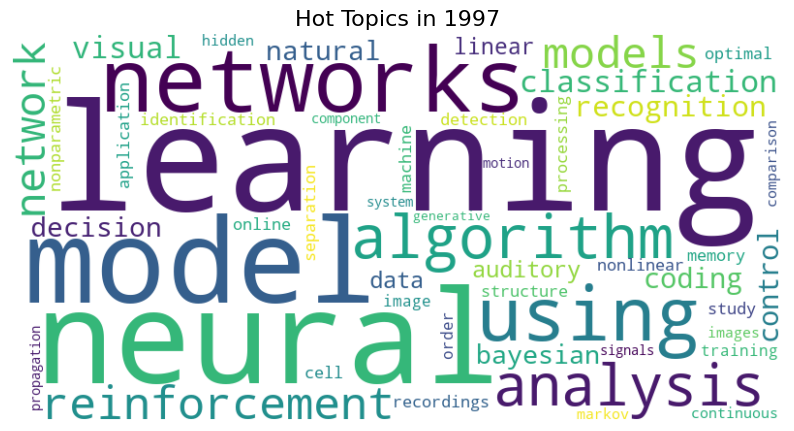

Top 5 Hot Topics for Year 1998:
  learning: 20.36
  using: 9.60
  models: 7.99
  networks: 7.92
  reinforcement: 6.87


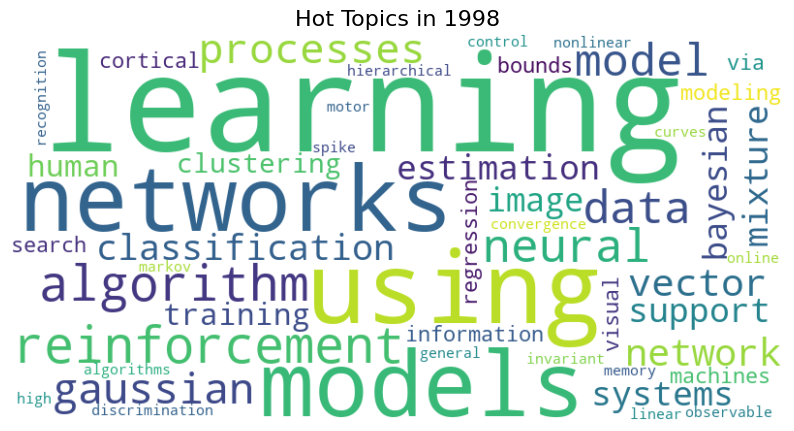

Top 5 Hot Topics for Year 1999:
  learning: 16.80
  model: 7.51
  bayesian: 7.29
  neural: 7.09
  models: 6.28


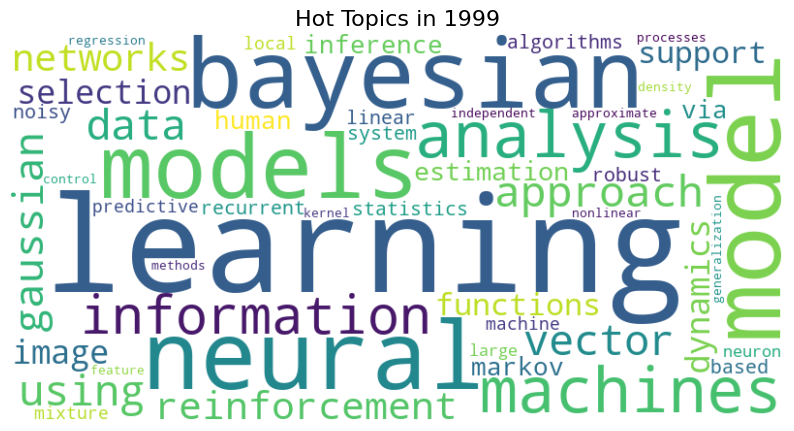

Top 5 Hot Topics for Year 2000:
  learning: 17.36
  networks: 8.22
  using: 7.56
  models: 7.07
  kernel: 6.04


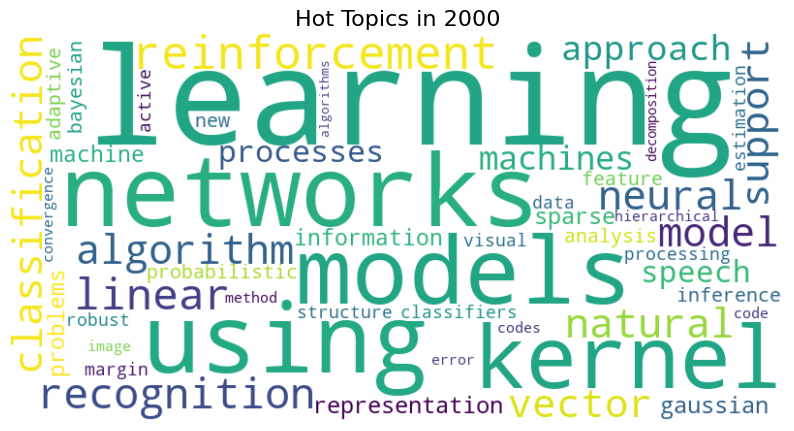

Top 5 Hot Topics for Year 2001:
  learning: 20.33
  model: 7.86
  using: 7.81
  kernel: 7.04
  bayesian: 6.65


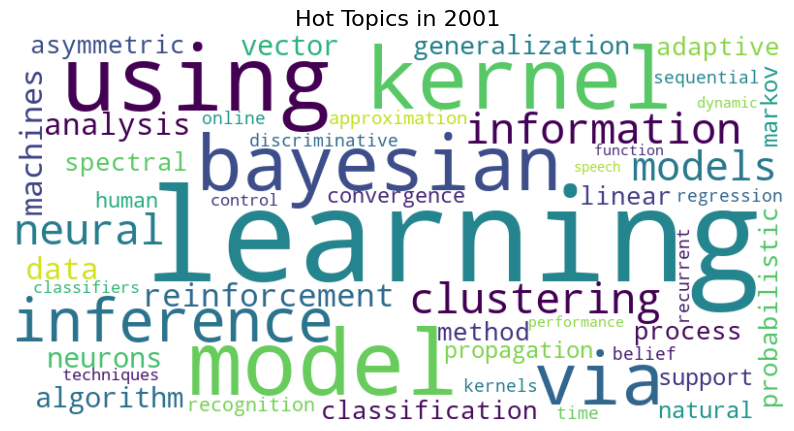

Top 5 Hot Topics for Year 2002:
  learning: 21.28
  model: 11.12
  bayesian: 7.55
  using: 7.50
  analysis: 7.45


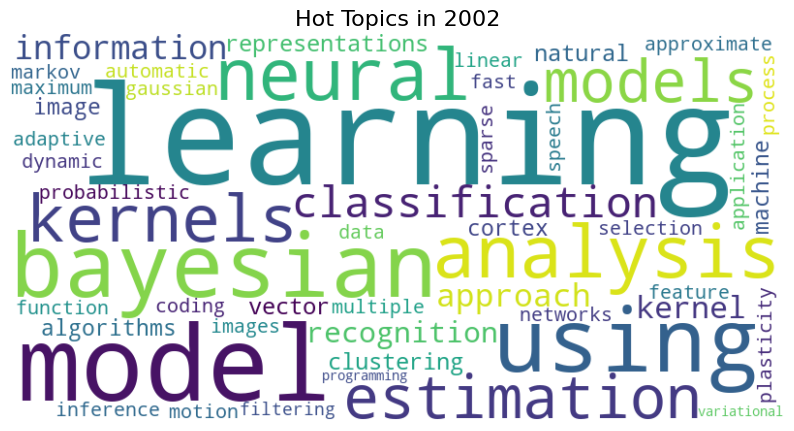

Top 5 Hot Topics for Year 2003:
  learning: 18.17
  model: 9.16
  models: 8.57
  classification: 7.53
  data: 7.48


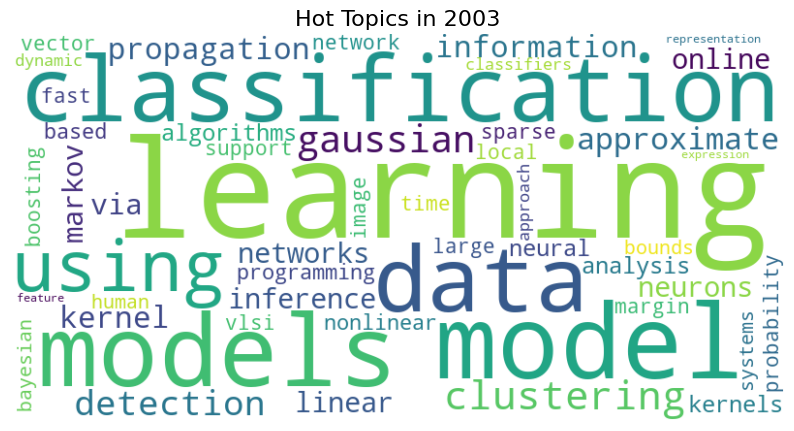

Top 5 Hot Topics for Year 2004:
  learning: 21.22
  model: 10.39
  using: 8.74
  classification: 7.62
  analysis: 7.62


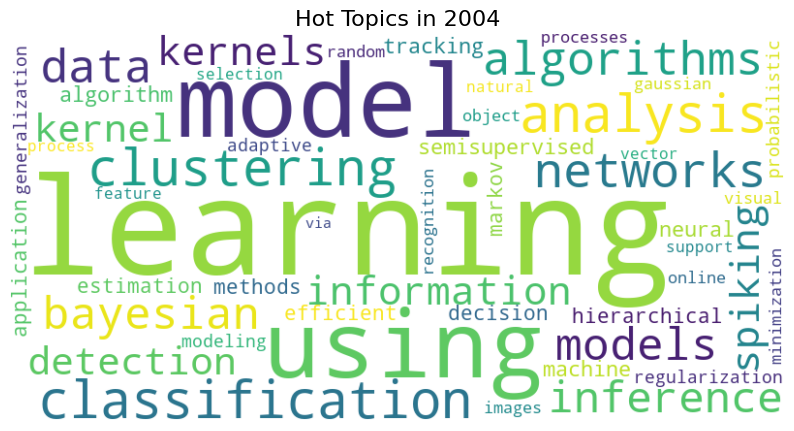

Top 5 Hot Topics for Year 2005:
  learning: 23.35
  models: 10.46
  analysis: 9.26
  visual: 7.69
  gaussian: 7.61


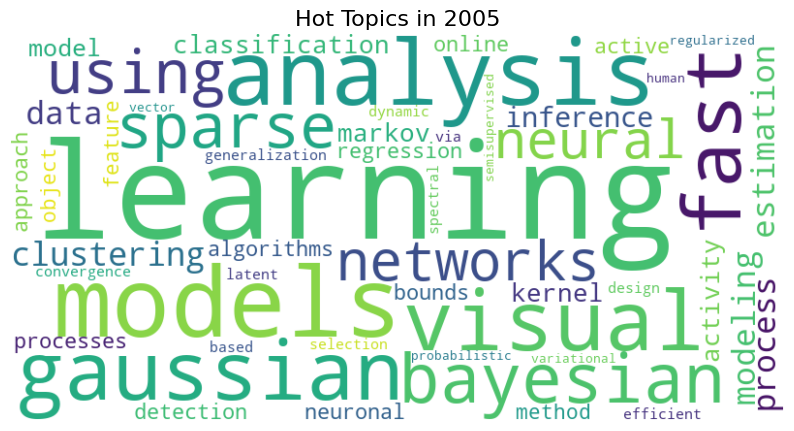

Top 5 Hot Topics for Year 2006:
  learning: 22.13
  bayesian: 10.95
  using: 10.42
  models: 8.89
  clustering: 8.79


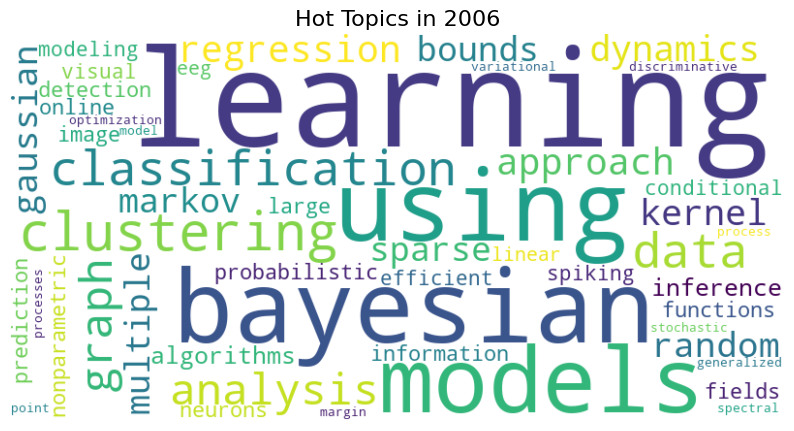

Top 5 Hot Topics for Year 2007:
  learning: 31.09
  model: 17.23
  using: 14.32
  models: 12.67
  data: 11.94


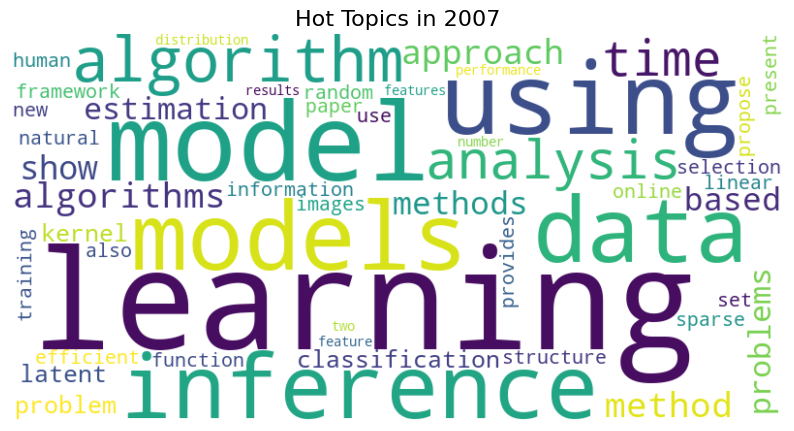

Top 5 Hot Topics for Year 2008:
  learning: 32.27
  model: 27.48
  data: 27.27
  models: 21.37
  algorithm: 20.33


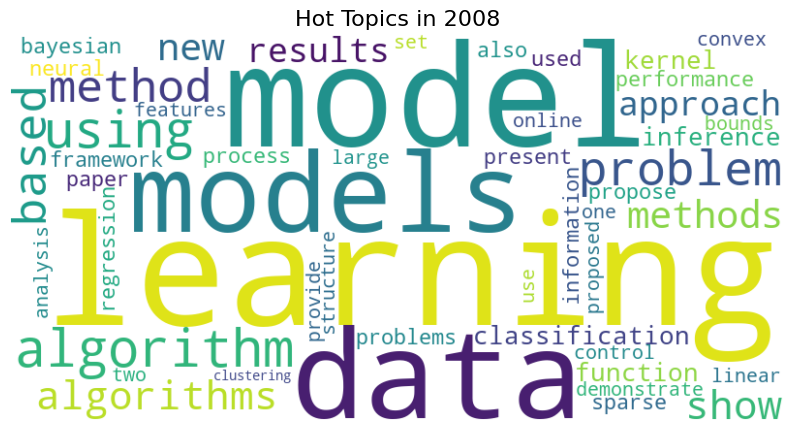

Top 5 Hot Topics for Year 2009:
  learning: 38.86
  model: 33.26
  models: 27.17
  data: 25.99
  algorithm: 24.31


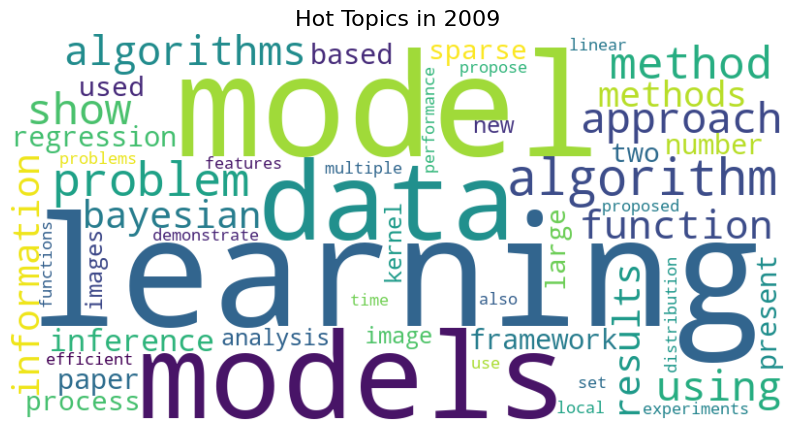

Top 5 Hot Topics for Year 2010:
  learning: 38.66
  model: 33.25
  data: 27.91
  algorithm: 26.82
  problem: 25.06


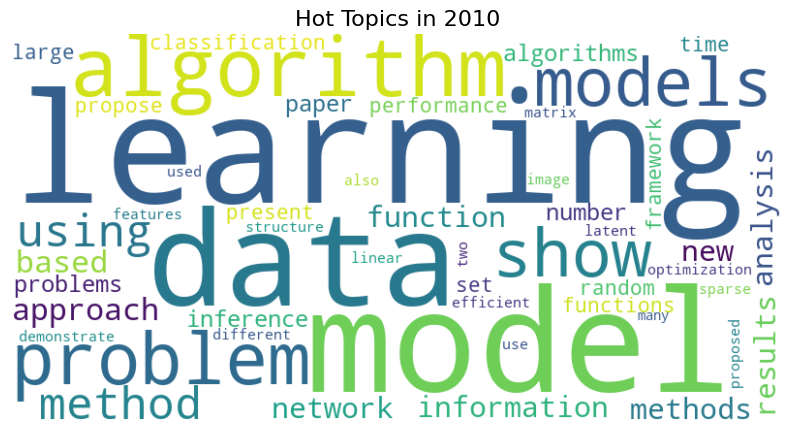

Top 5 Hot Topics for Year 2011:
  learning: 44.09
  data: 33.95
  algorithm: 31.16
  model: 31.06
  problem: 26.88


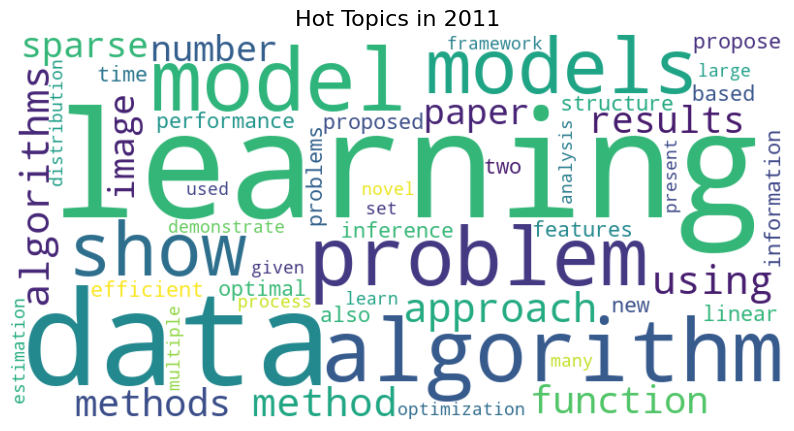

Top 5 Hot Topics for Year 2012:
  learning: 51.42
  model: 45.18
  data: 38.02
  models: 35.87
  algorithm: 31.05


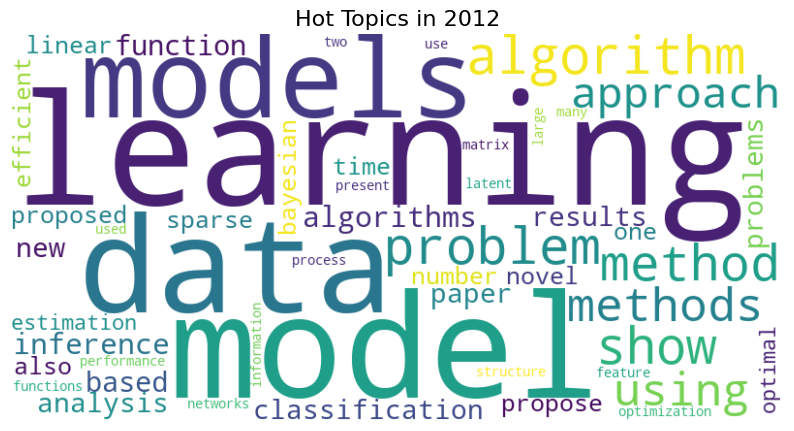

Top 5 Hot Topics for Year 2013:
  learning: 45.63
  algorithm: 37.83
  model: 37.45
  data: 36.08
  models: 32.38


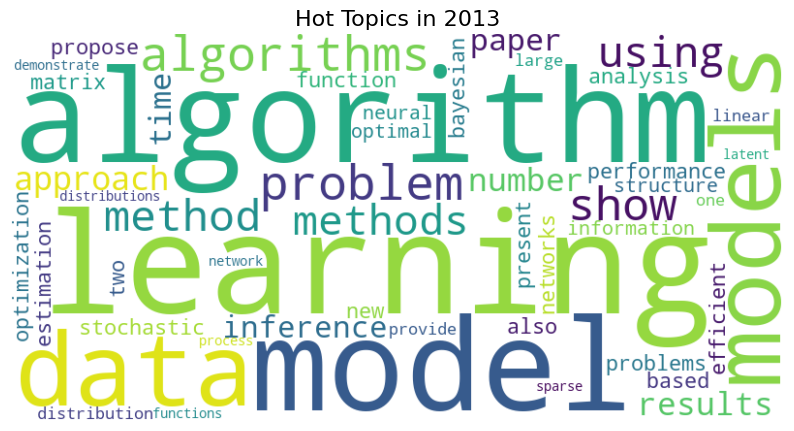

Top 5 Hot Topics for Year 2014:
  learning: 54.82
  model: 45.80
  algorithm: 45.79
  data: 41.93
  problem: 35.48


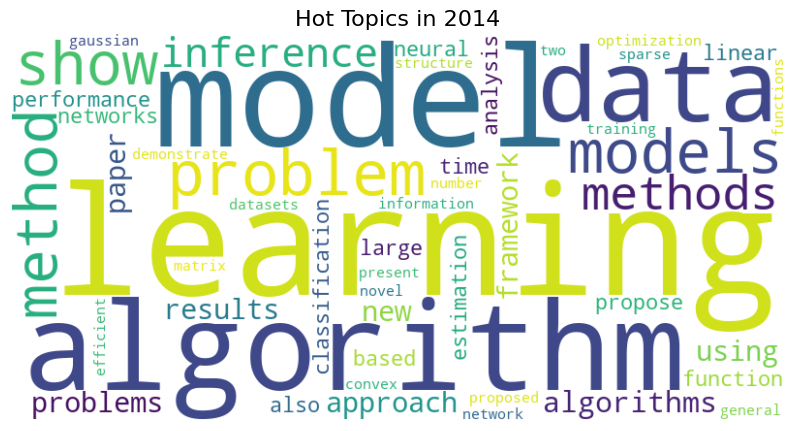

Top 5 Hot Topics for Year 2015:
  learning: 48.72
  model: 43.49
  algorithm: 43.27
  data: 39.14
  models: 34.01


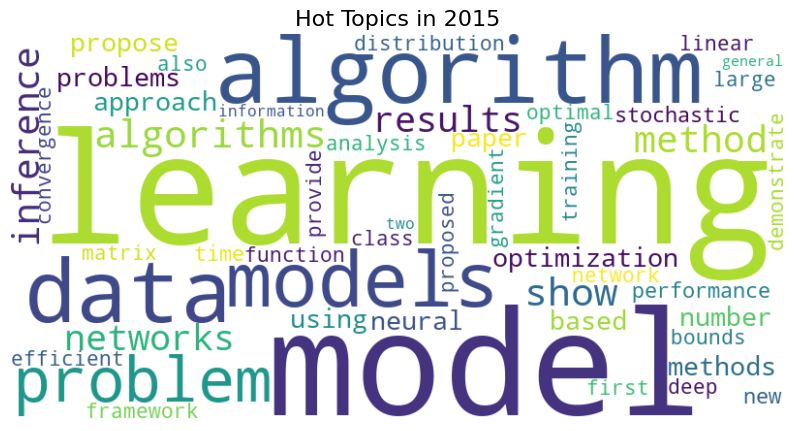

Top 5 Hot Topics for Year 2016:
  learning: 77.04
  data: 61.82
  model: 56.49
  algorithm: 56.21
  models: 51.08


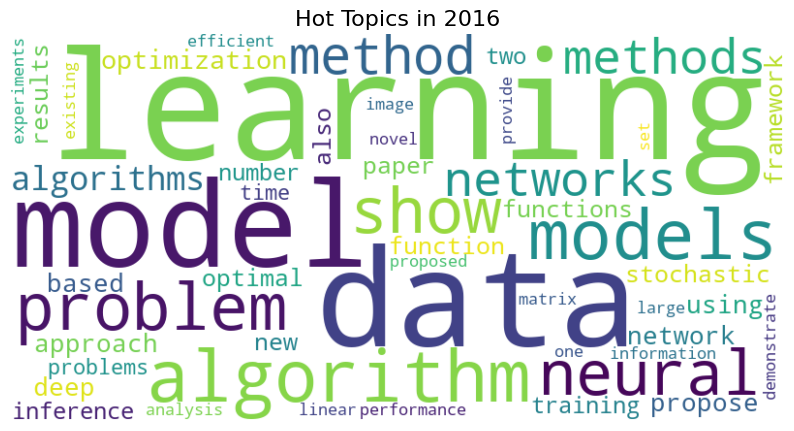

Top 5 Hot Topics for Year 2017:
  learning: 95.72
  data: 74.64
  model: 73.35
  algorithm: 63.25
  problem: 56.78


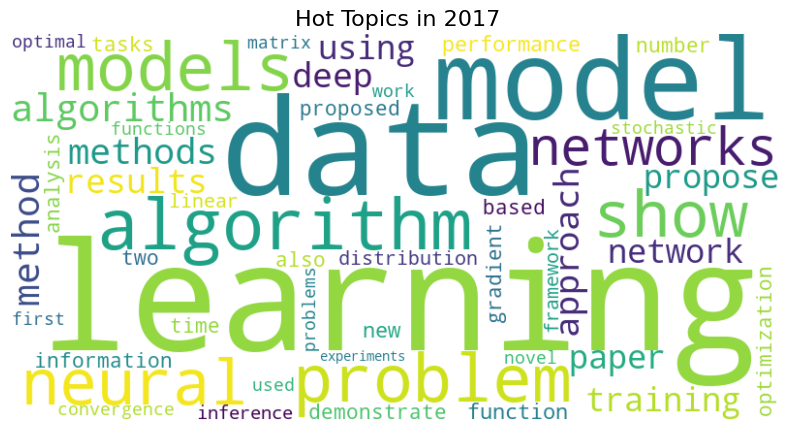

Top 5 Hot Topics for Year 2018:
  learning: 143.60
  model: 107.93
  data: 103.68
  algorithm: 89.09
  models: 87.02


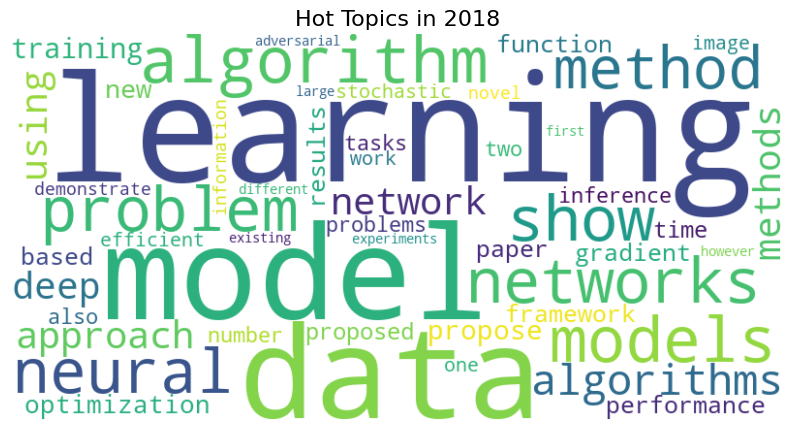

Top 5 Hot Topics for Year 2019:
  learning: 200.24
  model: 148.59
  data: 138.28
  algorithm: 128.59
  models: 125.82


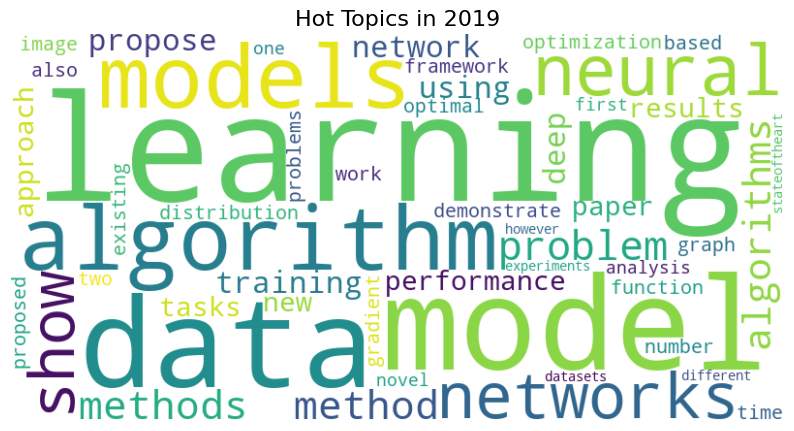


Final Answer:
{1987: [('neural', 14.93), ('networks', 14.5), ('learning', 7.48), ('network', 6.85), ('associative', 4.39), ('processing', 3.71), ('neurons', 3.44), ('memories', 3.14), ('classification', 2.78), ('memory', 2.6), ('analysis', 2.6), ('cortex', 2.55), ('learns', 2.47), ('electronic', 2.41), ('models', 2.38), ('net', 2.29), ('optimization', 2.2), ('based', 2.16), ('information', 2.1), ('application', 2.05), ('model', 2.02), ('using', 2.0), ('properties', 1.99), ('connectionist', 1.98), ('computational', 1.89), ('pattern', 1.87), ('speech', 1.87), ('nets', 1.84), ('system', 1.82), ('patterns', 1.78), ('systems', 1.78), ('artificial', 1.77), ('simulation', 1.68), ('approach', 1.66), ('selforganization', 1.65), ('optical', 1.63), ('distributed', 1.49), ('order', 1.46), ('probabilistic', 1.36), ('performance', 1.35), ('principle', 1.24), ('coding', 1.23), ('recognition', 1.23), ('capacity', 1.17), ('neuronlike', 1.16), ('control', 1.12), ('comparison', 0.98), ('required', 0.96)

In [18]:
# Create a state graph
workflow = StateGraph(SqlTfidfState)


# Add nodes for each step
workflow.add_node("write_query", write_query)
workflow.add_node("execute_query", execute_query)
workflow.add_node("generate_hot_topics", generate_hot_topics)
workflow.add_node("generate_answer", generate_answer)


# Define edges (workflow order)
workflow.add_edge("write_query", "execute_query")
workflow.add_edge("execute_query", "generate_hot_topics")
workflow.add_edge("generate_hot_topics", "generate_answer")


# Set the entry point and compile the graph
workflow.set_entry_point("write_query")
graph = workflow.compile()


# Running workflow
config = {"question": "What are the hot topics by year?"}
result = graph.invoke(config)

# Print the final answer
print("\nFinal Answer:")
print(result["answer"])


## 5. Combining authors and papers table to match each author to their respective papers written

In [20]:
# Query left joining papers <- authors on source_id first
# then takes "first_name" and "last_name" column from 
# authors and matches with the paper's "full_text" column to match 
query = """
SELECT  
    a.*, -- yes i know * is bad practice but its a small file, cut me some slack
    p.year AS year,
    p.title AS title,
    (a.first_name || ' ' || a.last_name) AS full_name,
    p.full_text
FROM
    papers_raw p
LEFT JOIN
    authors_raw a
    ON p.source_id = a.source_id
WHERE 1=1
    AND EXISTS(
        SELECT 1
        FROM papers_raw pr
        WHERE p.source_id = pr.source_id
            AND (
                SUBSTR(p.full_text, 1, 700) LIKE '%' || a.first_name || '%'
                AND SUBSTR(p.full_text, 1, 700) LIKE '%' || a.last_name || '%'
                )
        )
"""

combined = pd.read_sql(query, conn)
combined.to_sql('combined_clean', conn, if_exists = 'replace', index = False)
print("--- This is the combined data frame: ---")
display(combined.head())


index  source_id first_name    last_name institution  year  \
0      0         27       Alan       Murray        None  1987   
1      1         27    Anthony        Smith        None  1987   
2      2         27        Zoe       Butler        None  1987   
3      3         63      Yaser  Abu-Mostafa        None  1987   
4      4         60    Michael     Fleisher        None  1987   

                                         title          full_name  \
0                   Bit-Serial Neural Networks        Alan Murray   
1                   Bit-Serial Neural Networks      Anthony Smith   
2                   Bit-Serial Neural Networks         Zoe Butler   
3                  Connectivity Versus Entropy  Yaser Abu-Mostafa   
4  The Hopfield Model with Multi-Level Neurons   Michael Fleisher   

                                           full_text  
0  573 \n\nBIT - SERIAL NEURAL  NETWORKS \n\nAlan...  
1  573 \n\nBIT - SERIAL NEURAL  NETWORKS \n\nAlan...  
2  573 \n\nBIT - SERIAL NEURAL  NETWORKS \n\nAlan...  
3  1 \n\nCONNECTIVITY VERSUS ENTROPY \n\nYaser  S...  
4  278 \n\nTHE HOPFIELD MODEL WITH MUL TI-LEVEL N...

## Testing and debugging

In [19]:
test = """
SELECT *
FROM hot_topics
"""

test = pd.read_sql(test, conn)
display(test)

year           term  score
0     1987         neural  14.93
1     1987       networks  14.50
2     1987       learning   7.48
3     1987        network   6.85
4     1987    associative   4.39
...    ...            ...    ...
1645  2019    experiments  60.42
1646  2019       datasets  60.03
1647  2019      different  59.06
1648  2019  stateoftheart  58.28
1649  2019        however  58.17

[1650 rows x 3 columns]